# Overview

Using the [Ames, Iowa Housing Dataset](http://jse.amstat.org/v19n3/decock.pdf) I build a regularized regression model with  [Elastic Net](https://www.jstor.org/stable/3647580?seq=1#page_scan_tab_contents). 

This project has two objectives

- Build and train an elastic-net-regularized regression model to predict house prices

- Develop a standardized framework to structure the implementation of this model and models in future machine learning projects

In the process of developing a standardized framework, most of my time has been spent honing my skills with [Scikit Learn pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Pipelines provide a common framework to structure all steps of a data science project, from data preprocessing to prediction. By adhering to a standard framework more time may be spent on data analysis, feature extraction, and understanding the statistical models, and less time spent implementing these things.

## Thermidor

While developing this standard framework for data science projects I've created and utilized several functions and classes to streamline and simplify the process of pipeline construction. I've created a python module named [thermidor](https://github.com/rcorrero/thermidor) where these objects may be found. 

# Predictors

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

import joblib
import random

# Sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, power_transform, PowerTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet, enet_path
from sklearn.impute import SimpleImputer

In [3]:
X = pd.read_csv('./data/data.csv', index_col=[0])

## Split the data

We split the data into `train` and `test` (the size of each split is 1460 and 1459 cases, respectively. This is necessary for submission of predictions to [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)).

In [4]:
X_train, X_test = train_test_split(X, train_size=1460, test_size=1459, shuffle=False)

## Preliminary data analysis

Let's first check the `X_train` column names.

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 79 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

We see that the predictors include float, int, and object data types. Next we look at the data itself.

In [6]:
X_train.describe(include="all")

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
count,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,...,1460.000000,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460
unique,NaN,5,NaN,NaN,2,2,4,4,2,5,...,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6
top,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal
freq,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,...,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198
mean,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,...,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN
std,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,...,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN
min,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN
25%,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN
50%,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN
75%,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN


## Data Preprocessing

Let's get a list of all categorical features so that we can encode them down the line. Looking at the data, we see that all features of type 'object' are categorical, and the only other categorical feature is 'MSSubClass'. 

In [7]:
# Get list of categorical features in dataset
categorical = ['MSSubClass'] + [col for col in list(X.columns.values)
               if X[col].dtype == 'object']

# Get list of *NON*-categorical features in dataset
not_categorical = [col for col in list(X.columns.values)
               if col not in categorical]

### Missing Values

We see which columns contain missing values.

In [8]:
missing = X.columns[X.isnull().any()].to_list()

missing

['MSZoning',
 'LotFrontage',
 'Alley',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Electrical',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType']

Missing values clearly correspond to absence of a feature in some of these columns. For example, a missing entry for 'Exterior2nd' likely corresponds to a house which has no second floor and, therefore, no 2nd floor exterior. We put all such features in two lists: `to_none` and `to_zero`. `to_none` contains 'object' data type columns and `to_zero` contains `np.number` data types.

In [9]:
to_none = ['Alley', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond',
          'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
          'GarageType', 'GarageFinish', 'GarageQual', 
          'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

In [10]:
to_zero = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
          'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']

For other features its less likely that a missing value indicates absence of the feature. Since all houses (hopefully) have kitchens, it's likely that a missing entry in 'KitchenQual' simply indicates that this feature was not recorded for that specific house. Once again, we put all such features in two lists: `to_most_common` and `to_median`. `to_most_common` contains 'object' data type columns and `to_median` contains `np.number` data types.

In [11]:
to_most_common = ['MSZoning', 'Utilities', 'Exterior1st', 'Electrical', 'KitchenQual',
                  'Functional', 'SaleType']

In [12]:
to_median = ['LotFrontage']

Finally, let's get a list of all other columns: we'll use this in the `ColumnTransformer` laster.

In [13]:
no_na_cols = [col for col in X.columns.values.tolist() if col 
              not in (to_none + to_zero + to_most_common + to_median)]

## Preprocess pipeline &mdash; part one

Since we wish to analyze the correlation of the features in this data, we first need to perform imputation. To do so, we use a `ColumnTransformer`, which transforms columns specified in lists. We begin by constructing the transformers as pipelines. We use separate transformers for each of the lists of columns containing missing values so that we can perform the imputation methods appropriate to each. Further, we use pipelines here so that we may add new transformations on the data in the future.

In [14]:
# Transformer for 'to_none' columns
to_none_pipe = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='None')
)

In [15]:
# Transformer for 'to_zero' columns
to_zero_pipe = make_pipeline(
    SimpleImputer(strategy='constant', fill_value=0)
)

In [16]:
# Transformer for 'to_most_common' columns
to_most_common_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent')
)

In [17]:
# Transformer for 'to_median' columns
to_median_pipe = make_pipeline(
    SimpleImputer(strategy='median')
)

Now we combine these transformations using [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer).

In [18]:
# Creates imputed design matrix
impute_transformer = make_column_transformer(
    (to_none_pipe, to_none),
    (to_zero_pipe, to_zero),
    (to_most_common_pipe, to_most_common),
    (to_median_pipe, to_median),
    remainder='passthrough'
)

Since `ColumnTransformer` reorders the columns in the design matrix and strips the column names, we need to reapply the names in the new order. To do so we first construct a list with the names in the appropraite order.

In [19]:
col_names = to_none + to_zero + to_most_common + to_median + no_na_cols

### DataFramer

Using [DataFramer](https://github.com/rcorrero/thermidor/blob/master/thermidor/classes/data_framer.py) we convert the output of `ColumnTransformer` from `numpy.array` to a Pandas `DataFrame` and reapply the column names in order. This is the complete first part of the preprocess pipeline.

In [20]:
from thermidor import DataFramer

In [21]:
# Preprocess pipeline part one
impute_pipe = make_pipeline(
    impute_transformer,
    DataFramer(col_names)
)

This pipeline transforms the design matrix by imputing all missing values as specified above.

In [22]:
X_imputed = impute_pipe.fit_transform(X_train)

## Correlation

We first plot the correlation of the numeric features in the `train` data.

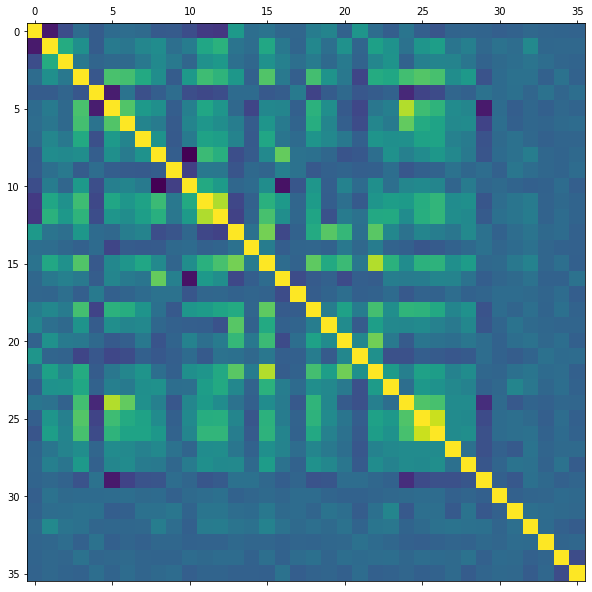

In [23]:
X_train_cor = X_train.corr()
plt.figure(figsize=(10,10))
plt.matshow(X_train_cor, fignum=1)
plt.show()

Next, let's identify any relatively large correlations among numeric features. Because `correlation` uses the Pearson and Spearman correlation functions from `scipy.stats`, we must have no missing values in the feature columns to calculate correlation, and this is why we needed to impute missing values before this point. 

In [24]:
from thermidor import correlation

In [25]:
# Minimum |correlation| = .8
large_corr = correlation(X_imputed, .8)

In [26]:
large_corr

[(0.8584872567634689, 'Exterior2nd', 'Exterior1st'),
 (-0.8960687885891644, 'BsmtFinType2', 'BsmtFinSF2'),
 (-0.9999911109711231, 'PoolQC', 'PoolArea'),
 (0.9028952966055307, 'MiscFeature', 'MiscVal'),
 (0.8292919303569337, 'TotalBsmtSF', '1stFlrSF'),
 (0.8643713518677583, 'GarageYrBlt', 'YearBuilt'),
 (0.8533173766076401, 'GarageCars', 'GarageArea'),
 (0.8278743231158385, 'GrLivArea', 'TotRmsAbvGrd')]

We see that several predictors are strongly correlated, which suggests that regularization is desirable in this case.

## Preprocess pipeline &mdash; part two

We now create a pipeline which encodes categorical features using [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and then standardizes all features. We standardize _all_ features, including factors, because this [helps in the regularization process](https://web.stanford.edu/~hastie/Papers/B67.2%20(2005)%20301-320%20Zou%20&%20Hastie.pdf).

In [27]:
# Create ColumnTransformer for one-hot encoding
encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', sparse=False), categorical),
    remainder='passthrough'
)

In [28]:
# Preprocess pipeline part two
encode_pipe = make_pipeline(
    encoder,
    StandardScaler(),
    DataFramer() # Convert back to pandas DataFrame
)

## Full preprocess pipeline

Now we bring both parts of the preprocess pipeline together.

In [29]:
# Full preprocess pipeline
preprocess_pipe = make_pipeline(
    impute_pipe,
    encode_pipe
)

Let's use this pipeline to transform `X_train` for use later.

In [30]:
X_transformed = preprocess_pipe.fit_transform(X_train)

### DummyEstimator

Even though we will only use Elastic Net in this project, it's helpful to wrap the regressor with [DummyEstimator](). `DummyEstimator` allows us to treat the model _itself_ as a parameter in the pipeline, and therefore multiple models may be compared in one fit.

In [31]:
from thermidor import DummyEstimator

## Full pipeline

We now have everything we need to construct the complete pipeline combining data processing with the elastic net regressor.

In [32]:
full_pipe = make_pipeline(
    preprocess_pipe,
    DummyEstimator()
)

# Response

In [33]:
Y_train = pd.read_csv('./data/response.csv', index_col=[0])

Elastic net [requires](https://web.stanford.edu/~hastie/Papers/B67.2%20(2005)%20301-320%20Zou%20&%20Hastie.pdf) the response be centered. Let's look at the distribution of the response data and determine whether a transformation is appropriate.

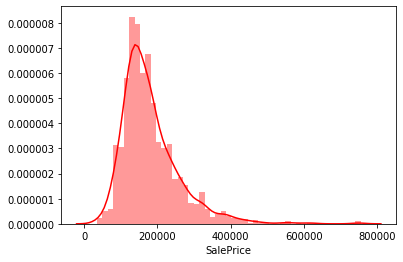

In [34]:
sns.distplot(Y_train['SalePrice'], kde=True, color='r')

The response is clearly skewed, which makes sense when dealing with house prices. We scale the response using a [power transformation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html).

In [35]:
# Response transformer
transformer = PowerTransformer(method='box-cox', standardize=True)

Let's transform the response for use later.

In [36]:
Y_transformed = power_transform(Y_train, method='box-cox', standardize=True)

# Hyperparameters

[ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet) takes two hyperparameters, `alpha` and `l1_ratio`. `alpha` controls the amount of regularization, and `l1_ratio` controls the shape of the penalty.

Also this is the appropriate place to tell the pipeline that we intend to use `ElasticNet`.

In [37]:
# Specify hyperparams
hyperparameters = { 'regressor__dummyestimator__estimator': [ElasticNet()],
                    'regressor__dummyestimator__estimator__l1_ratio': 
                    [0, .001, .005, .01, .05, .1, .5, .99, 1],
                    'regressor__dummyestimator__estimator__alpha':
                    [.01, .10, .125, .15, .175, .20, .5, 3, 5]
                  }

# Full regressor

We may now create the complete regressor pipeline using [TransformTargetRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html).

In [39]:
enet_regressor = TransformedTargetRegressor(
                      regressor = full_pipe,
                      transformer = transformer
             )

# Fit and train the model

We use [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to fit train the model using `X_train`.

In [40]:
# Specify search parameters
enet_model = GridSearchCV(enet_regressor, hyperparameters, cv=5)

In [41]:
# Fit the model
enet_model.fit(X_train, Y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.789406765720955, tolerance: 0.11679999999999999
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.42854238645757, tolerance: 0.1168
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.377688327075376, tolerance: 0.1168
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.95587210007221, tolerance: 0.11680000000000003
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.01585123438787, tolerance: 0.1168
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.7098114499283, tolerance: 0.11679999999999999
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinat

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=TransformedTargetRegressor(check_inverse=True, func=None,
                                                  inverse_func=None,
                                                  regressor=Pipeline(memory=None,
                                                                     steps=[('pipeline',
                                                                             Pipeline(memory=None,
                                                                                      steps=[('pipeline-1',
                                                                                              Pipeline(memory=None,
                                                                                                       steps=[('columntransformer',
                                                                                                               ColumnTransformer(n_jobs=None,
                              

Let's see which parameters `GridSearch` selected.

In [42]:
enet_model.best_params_

{'regressor__dummyestimator__estimator': ElasticNet(alpha=3, copy_X=True, fit_intercept=True, l1_ratio=0, max_iter=1000,
            normalize=False, positive=False, precompute=False, random_state=None,
            selection='cyclic', tol=0.0001, warm_start=False),
 'regressor__dummyestimator__estimator__alpha': 3,
 'regressor__dummyestimator__estimator__l1_ratio': 0}

In [43]:
# Get l1_ratio
l1_ratio = enet_model.best_params_['regressor__dummyestimator__estimator__l1_ratio']
alpha = enet_model.best_params_['regressor__dummyestimator__estimator__alpha']

## Show elastic net paths

We create a plot showing the paths of the regularized coefficients as `alpha` changes. To do so we need to use [enet_path](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.enet_path.html).

In [44]:
# Length of the path
eps = 1e-5

# Compute path for plotting
alphas_enet, coefs_enet, _ = enet_path(X_transformed, Y_transformed,
                                       alphas = hyperparameters['regressor__dummyestimator__estimator__alpha'],
                                       l1_ratio = l1_ratio, eps = eps, fit_intercept = False)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:462: UserWarning: Coordinate descent with l1_reg=0 may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:462: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247.36928586300857, tolerance: 0.146
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:462: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193.3552426478342, tolerance: 0.146
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random)
/Library/Frameworks/Python.framework/Versions/3

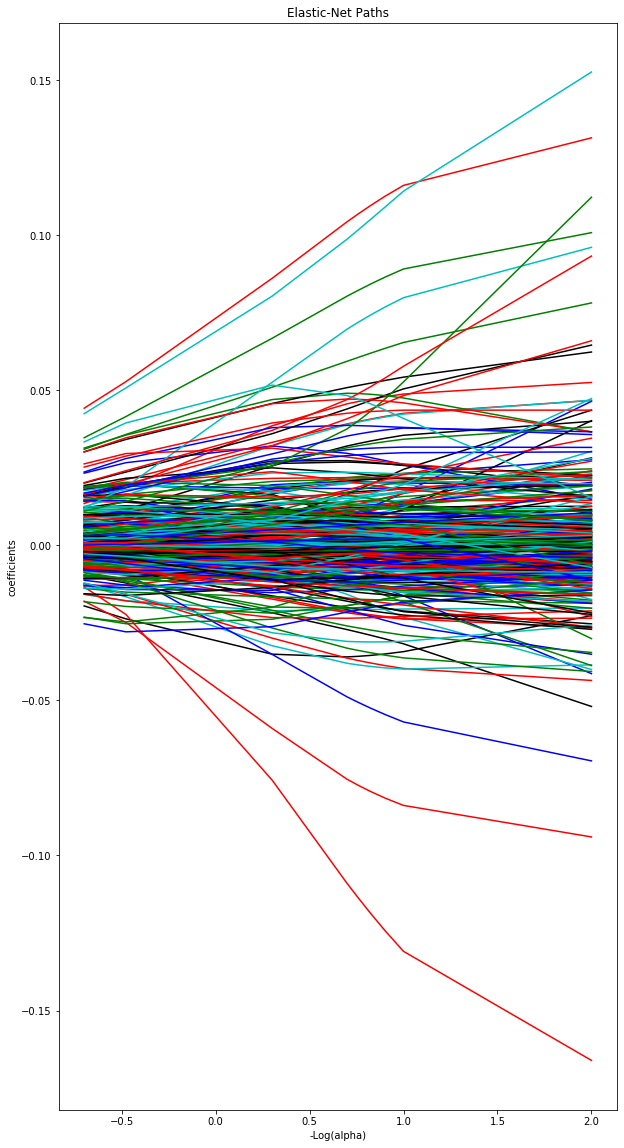

In [45]:
# Display results
plt.figure(figsize=(10,20))
colors = ['b', 'r', 'g', 'c', 'k']

neg_log_alphas_enet = -np.log10(alphas_enet)

for coef_e in coefs_enet[0,:,:]:
    l1 = plt.plot(neg_log_alphas_enet, coef_e, c = random.choice(colors))

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic-Net Paths')
plt.axis('tight')
plt.show()

# Save the fitted model

Now that we've fit and trained the model, let's save it so that we can reuse it to make predictions on new data in the future. We'll save the model as a [.pkl](https://docs.python.org/3/library/pickle.html) file.

In [46]:
joblib.dump(enet_model, 'enet_model.pkl', compress=True) 

['enet_model.pkl']

# Create predictions

Finally, we predict the response from our training data.

In [47]:
predictions = enet_model.predict(X_test)

In [48]:
predictions

array([[125549.53277943],
       [156263.3887577 ],
       [182403.4652609 ],
       ...,
       [162745.78210538],
       [115791.26627818],
       [209420.39251323]])

In [49]:
predictions = predictions.flatten()

In [50]:
# Get indices from test data
indices = X_test.iloc[:,0]

We prepare these predictions for submission.

In [51]:
# Convert for submission
solution = pd.DataFrame({"id":indices, "SalePrice":predictions})
solution.to_csv("predictions.csv", index = False)